In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
import sys
from darts.models.forecasting.xgboost import XGBModel

sys.path.append("..")
from darts.metrics import rmse
df = pd.read_csv('../data/data_for_darts_normalized_by_test.csv', index_col=0, parse_dates= True)




def get_timeseries(df):
    df = df.loc[df.index.weekday < 5]
    series = TimeSeries.from_dataframe(df,freq = 'B') 
    series = fill_missing_values(series)
    return series


best_longer = pd.read_csv("../data/best_covs_longer.csv",index_col=0,parse_dates=True).drop(columns='time_as_number')
longer_covs = get_timeseries(best_longer)

/home/felix/anaconda3/envs/bbdc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
salts = pd.read_csv("../covariaties/salts.csv",index_col=0,parse_dates=True)
salts.index = salts.index.date

In [3]:
smaller = best_longer.loc[best_longer.index.year > 1993]
smaller = smaller.join(salts[["all_salt", "closest_salt"]])
smaller["salt_missing"] = smaller.all_salt.isna().astype(int)
smaller

with_salt = get_timeseries(smaller)

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
val_df = df.loc[(df.index.year == 2005) | (df.index.year == 2006)].iloc[:,:6]
train_df = df.loc[df.index.year > 2006].iloc[:,:6]

val_x = val_df.iloc[:,:5]
val_y = val_df.NOx
train_x =  train_df.iloc[:,:5]
train_y = train_df.NOx


switcher = GradientBoostingRegressor(random_state=0
)

switcher.fit(train_x,train_y)

vals = switcher.predict(val_x)
np.sqrt(np.mean(np.square(vals - val_y)))

0.12444790141129632

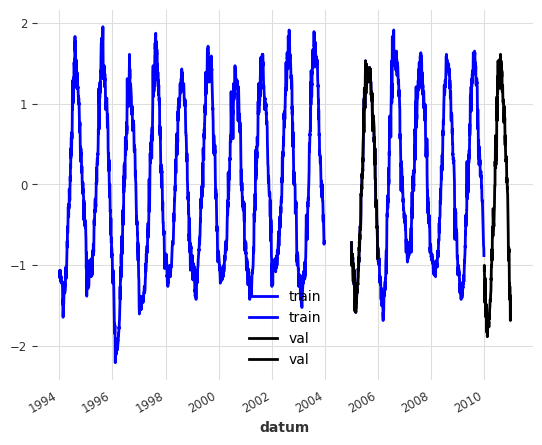

In [5]:
data_df = df.iloc[3:].copy()

data_df.loc[data_df.index.year < 2004,'NOx'] = switcher.predict(data_df.iloc[data_df.index.year < 2004,:5])

train1 = get_timeseries(data_df.loc[(data_df.index.year > 1993) & (data_df.index.year <= 2003)])
train2 = get_timeseries(data_df.loc[(data_df.index.year > 2004) & (data_df.index.year <= 2009)])

val1 =  get_timeseries(data_df.loc[data_df.index.year == 2005])
val2 =  get_timeseries(data_df.loc[data_df.index.year == 2010])

train1['Temperatur'].plot(label = "train",c = "blue")
train2['Temperatur'].plot(label = "train",c = "blue")
val1['Temperatur'].plot(label = "val", c= "black")
val2['Temperatur'].plot(label = "val", c= "black")

In [6]:
def best_xgm_model(multi_models = True):
    
    params = {'learning_rate': 0.07014188001597053, 'max_depth': 4, 'gamma': 1.0518764146499875, 'reg_alpha': 0.0070217178903161925, 'reg_lambda': 0.2538094460672119, 'colsample_bytree': 0.6221196927178515, 'min_child_weight': 10, 'n_estimators': 294, 'in_len': 14, 'out_len': 3, 'lags_lower': 11, 'upper_lag': 9}
    in_len = params.pop('in_len')
    out_len = params.pop("out_len")


    lags_lower = params.pop("lags_lower") 
    lags_upper = params.pop("upper_lag") 
    return XGBModel(lags = in_len,
                        lags_future_covariates = (lags_lower,lags_upper),
                        output_chunk_length=out_len, 
                        seed = 0,
                        tree_method = 'gpu_hist',
                        **params, multi_models=multi_models)

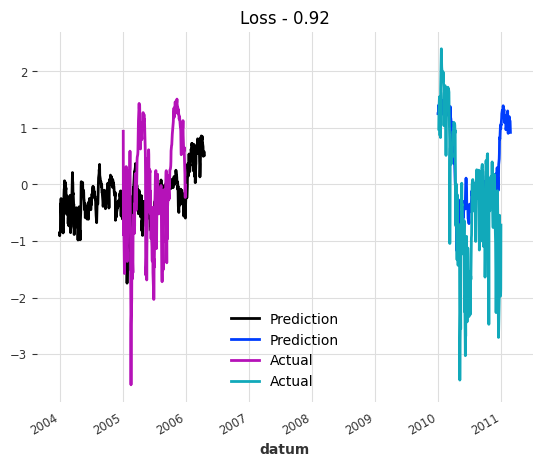

In [7]:
from darts.metrics import mse
model = best_xgm_model()
model.fit([train1['Salinität'],train2['Salinität']],  future_covariates=[longer_covs,longer_covs])

p1 = model.predict(600,train1['Salinität'],future_covariates=longer_covs)
p2 = model.predict(300,train2['Salinität'],future_covariates=longer_covs)

p1.plot(label='Prediction')
p2.plot(label='Prediction')
val1['Salinität'].plot(label = 'Actual')
val2['Salinität'].plot(label = 'Actual')
loss = np.sqrt( (mse(p1,val1['Salinität']) + mse(p2,val2['Salinität']))/2)
plt.title(f"Loss - {float(loss):.2f}")
plt.show()

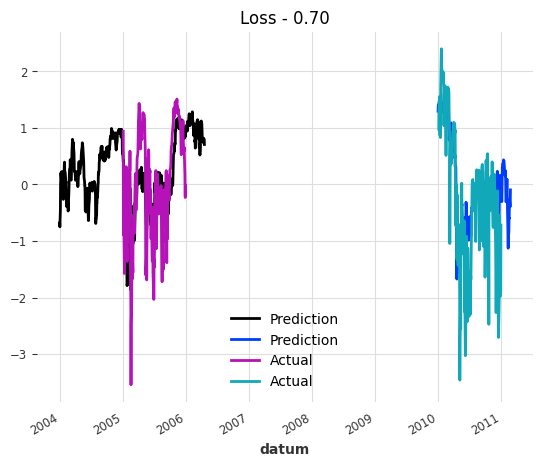

In [8]:
from darts.metrics import mse
model = best_xgm_model()
model.fit([train1['Salinität'],train2['Salinität']],  future_covariates=[with_salt,with_salt])

p1 = model.predict(600,train1['Salinität'],future_covariates=with_salt)
p2 = model.predict(300,train2['Salinität'],future_covariates=with_salt)

p1.plot(label='Prediction')
p2.plot(label='Prediction')
val1['Salinität'].plot(label = 'Actual')
val2['Salinität'].plot(label = 'Actual')
loss = np.sqrt( (mse(p1,val1['Salinität']) + mse(p2,val2['Salinität']))/2)
plt.title(f"Loss - {float(loss):.2f}")
plt.show()

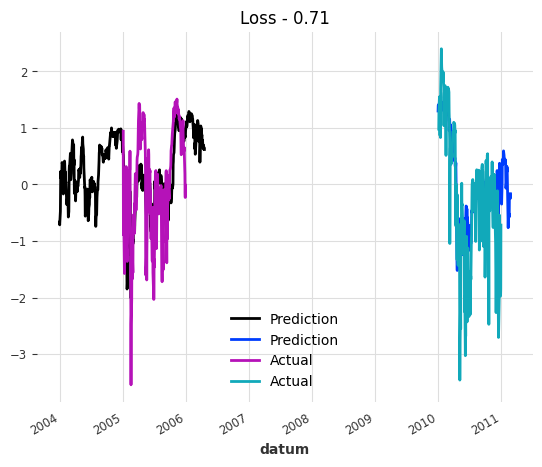

In [9]:
from darts.metrics import mse
model = best_xgm_model()
model.fit([train1[['Temperatur','Salinität']],train2[['Temperatur','Salinität']]],  future_covariates=[with_salt,with_salt])

p1 = model.predict(600,train1[['Temperatur','Salinität']],future_covariates=with_salt)["Salinität"]
p2 = model.predict(300,train2[['Temperatur','Salinität']],future_covariates=with_salt)["Salinität"]

p1.plot(label='Prediction')
p2.plot(label='Prediction')
val1['Salinität'].plot(label = 'Actual')
val2['Salinität'].plot(label = 'Actual')
loss = np.sqrt( (mse(p1,val1['Salinität']) + mse(p2,val2['Salinität']))/2)
plt.title(f"Loss - {float(loss):.2f}")
plt.show()

<Axes: xlabel='datum'>

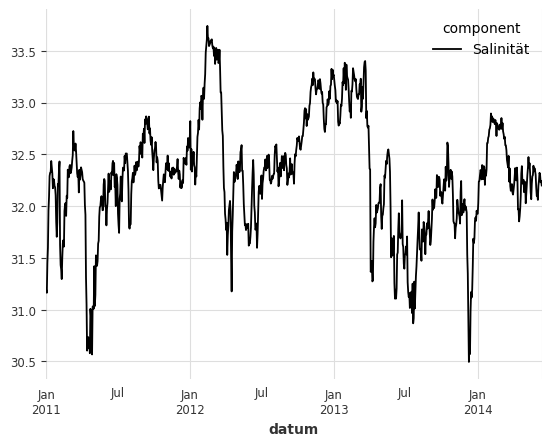

In [10]:
import json
with open("../data/bbdc_student/means.json") as f:
    means = json.load(f)
    
with open("../data/bbdc_student/variances.json") as f:
    stds = np.sqrt(pd.Series(json.load(f)))


def rescale(x):
    return (x * stds["Salinität"]) + means["Salinität"]

salt_2004 = model.predict(300,train1[['Temperatur','Salinität']],future_covariates=with_salt)['Salinität']
salt_2004 = salt_2004.pd_dataframe()
salt_2004 = rescale(salt_2004)
salt_2011_12 = model.predict(900,val2[['Temperatur','Salinität']],future_covariates=with_salt)['Salinität']
salt_2011_12 = salt_2011_12.pd_dataframe()
salt_2011_12 = rescale(salt_2011_12)

salt_2011_12.plot()


In [11]:
import os

if not os.path.exists("student_submission.csv"):
    
    pd.read_csv("../data/bbdc_student/bbdc_2023_AWI_data_evaluate_skeleton_student.csv",delimiter=';').to_csv("student_submission.csv",sep = ';',index= False)

<Axes: xlabel='Datum'>

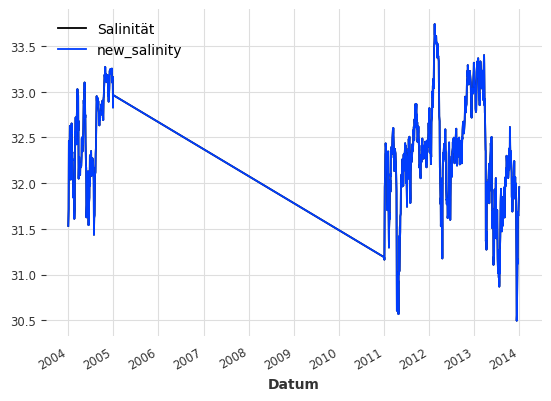

In [12]:
v5 = pd.read_csv('student_submission.csv', delimiter=';',skiprows=[1])
v5.index = pd.to_datetime(v5.Datum,dayfirst=True)

v5['new_salinity'] = 32
indices = pd.DatetimeIndex(list(set(v5.index).intersection(salt_2004.index)))
v5.loc[indices,'new_salinity'] = salt_2004.loc[indices].values


indices = pd.DatetimeIndex(list(set(v5.index).intersection(salt_2011_12.index)))
v5.loc[indices,'new_salinity'] = salt_2011_12.loc[indices].values

v5[['Salinität','new_salinity']].plot()

In [13]:
submission_ds =v5.copy()
submission_ds.Salinität = submission_ds.pop("new_salinity")
submission_ds = submission_ds[v5.columns[:-1]]
submission_ds

,Datum,Uhrzeit,SECCI,Temperatur,Salinität,NO2,NO3,NOx
Datum,,,,,,,,
2004-01-02,02.01.2004,7:34,NaN,6.581663,31.532833,2.177445,6.756799,8.242342
2004-01-05,05.01.2004,14:10,NaN,6.353498,31.714422,2.215712,6.567557,7.237238
2004-01-06,06.01.2004,9:05,NaN,6.383973,32.172222,2.305337,7.314351,10.064106
2004-01-07,07.01.2004,8:30,NaN,6.612460,32.460583,2.364508,7.365722,9.626233
2004-01-08,08.01.2004,9:00,NaN,6.554323,32.338295,2.426843,8.071082,9.318603
...,...,...,...,...,...,...,...,...
2013-12-18,18.12.2013,7:52,NaN,8.225276,31.197153,1.237329,8.153950,9.224953
2013-12-19,19.12.2013,9:09,NaN,8.168206,31.416368,1.249463,8.136104,7.689782
2013-12-20,20.12.2013,8:00,NaN,8.047997,31.685492,1.244565,7.858426,8.325728


In [14]:
submission_ds.to_csv('student_submission.csv',sep = ';',index= False)
with open("../data/bbdc_student/bbdc_2023_AWI_data_evaluate_skeleton_student.csv","r") as f:
    metrics = f.read().splitlines()[1]
with open('student_submission.csv',"r") as f:
    lines = f.read().splitlines()
lines.insert(1,metrics)


with open('student_submission.csv',"w") as f:
    f.write("\n".join(lines))